# Displaying Module Graphs
In the context of digital circuit design, a module graph is a directed acyclic graph that represents the structure of a module.
It contains the ports of the module and all instances (primitive gates and submodules) as nodes, whereas wires are represented by edges.
Module graphs can be visualized using graph visualization tools like Graphviz or Gephi and can be managed using NetworkX in Python.

## Simple Visualization of Module Graphs
- NetworkX graphs can be visualized using `networkx.draw`.
- Execute the cell below to load the decentral multiplexer and display its module graph.

Building Edges: 100%|██████████| 67/67 [00:00<00:00, 4234.56it/s]


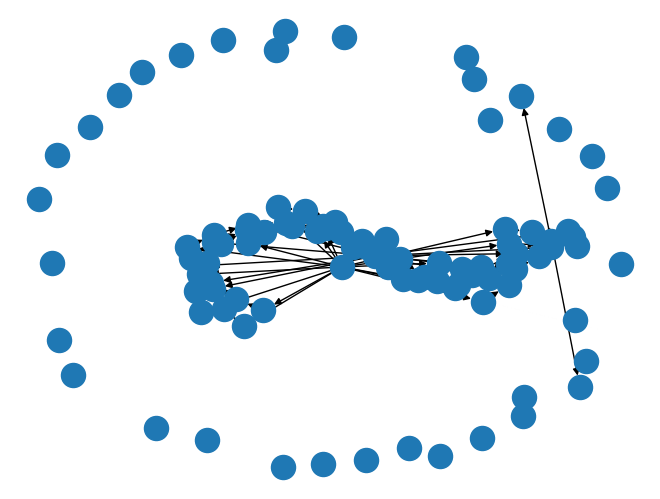

In [1]:
import networkx as nx

import netlist_carpentry

circuit = netlist_carpentry.read("files/decentral_mux.v", top="decentral_mux")
original_module_graph = circuit.top.graph()
nx.draw(original_module_graph)

- As can be seen in the graph representation, there are a couple of nodes without outgoing or incoming edges.
- In the decentral mux, this is due to a `genvar` used to describe the multiplexer's behavior in a `for` loop.
- Yosys includes this integer as a wire, and since it originally consisted of 32 bit, Yosys implemented a 32-bit constant wire that is driven by constant buffer elements (i.e. buffers that are tied to a certain value) in the netlist.
- To remove these useless constructs, `Module.optimize` can be used.
- Execute the cell below to optimize the module and re-render the graph afterwards, without the useless nodes.

Building Edges: 100%|██████████| 65/65 [00:00<00:00, 4554.15it/s]


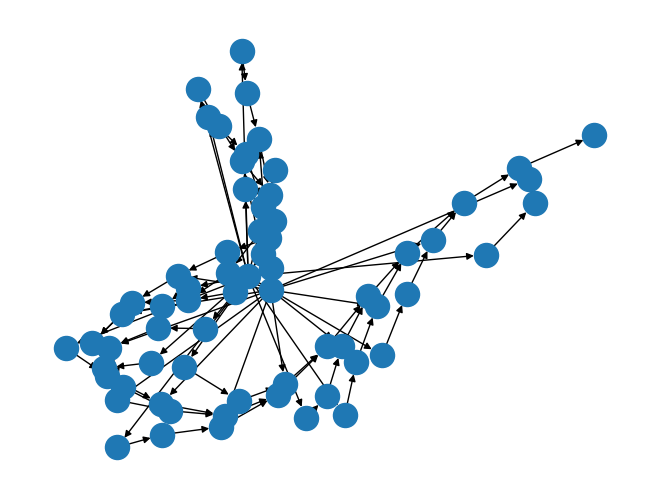

In [2]:
circuit.top.optimize()
optimized_module_graph = circuit.top.graph()
nx.draw(optimized_module_graph)

## Customizing the Graph Representation
- To customize the visualization, use a layout algorithm to position nodes in the graph.
- The Kamada-Kawai layout is used here, since it is a force-directed layout, where edges are treated as springs pulling connected nodes together, while non-connected nodes repel each other.
- Execute the cell below to render the module graph using this layout algorithm.

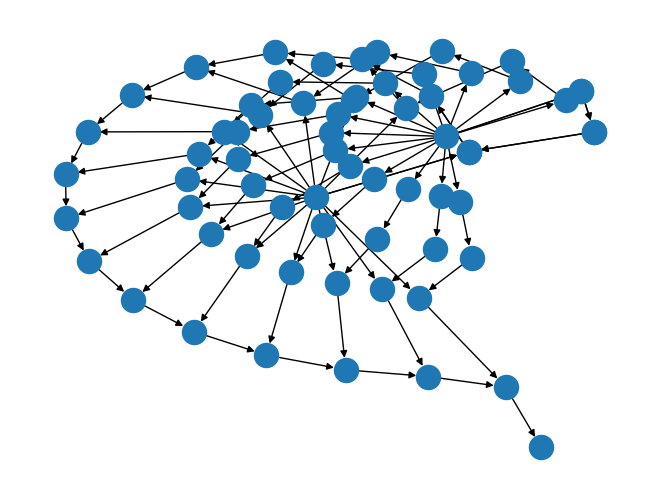

In [3]:
pos = nx.kamada_kawai_layout(optimized_module_graph)
nx.draw(optimized_module_graph, pos)

- To label the nodes (i.e. make them display their instance names), the parameter `with_labels` can be used.
- Also, using `matplotlib`, the figure size can be increased to force the algorithm to place the nodes and labels in a more readable manner.
- Execute the cell below to render the module graph in a more stretched version and with labelled nodes.

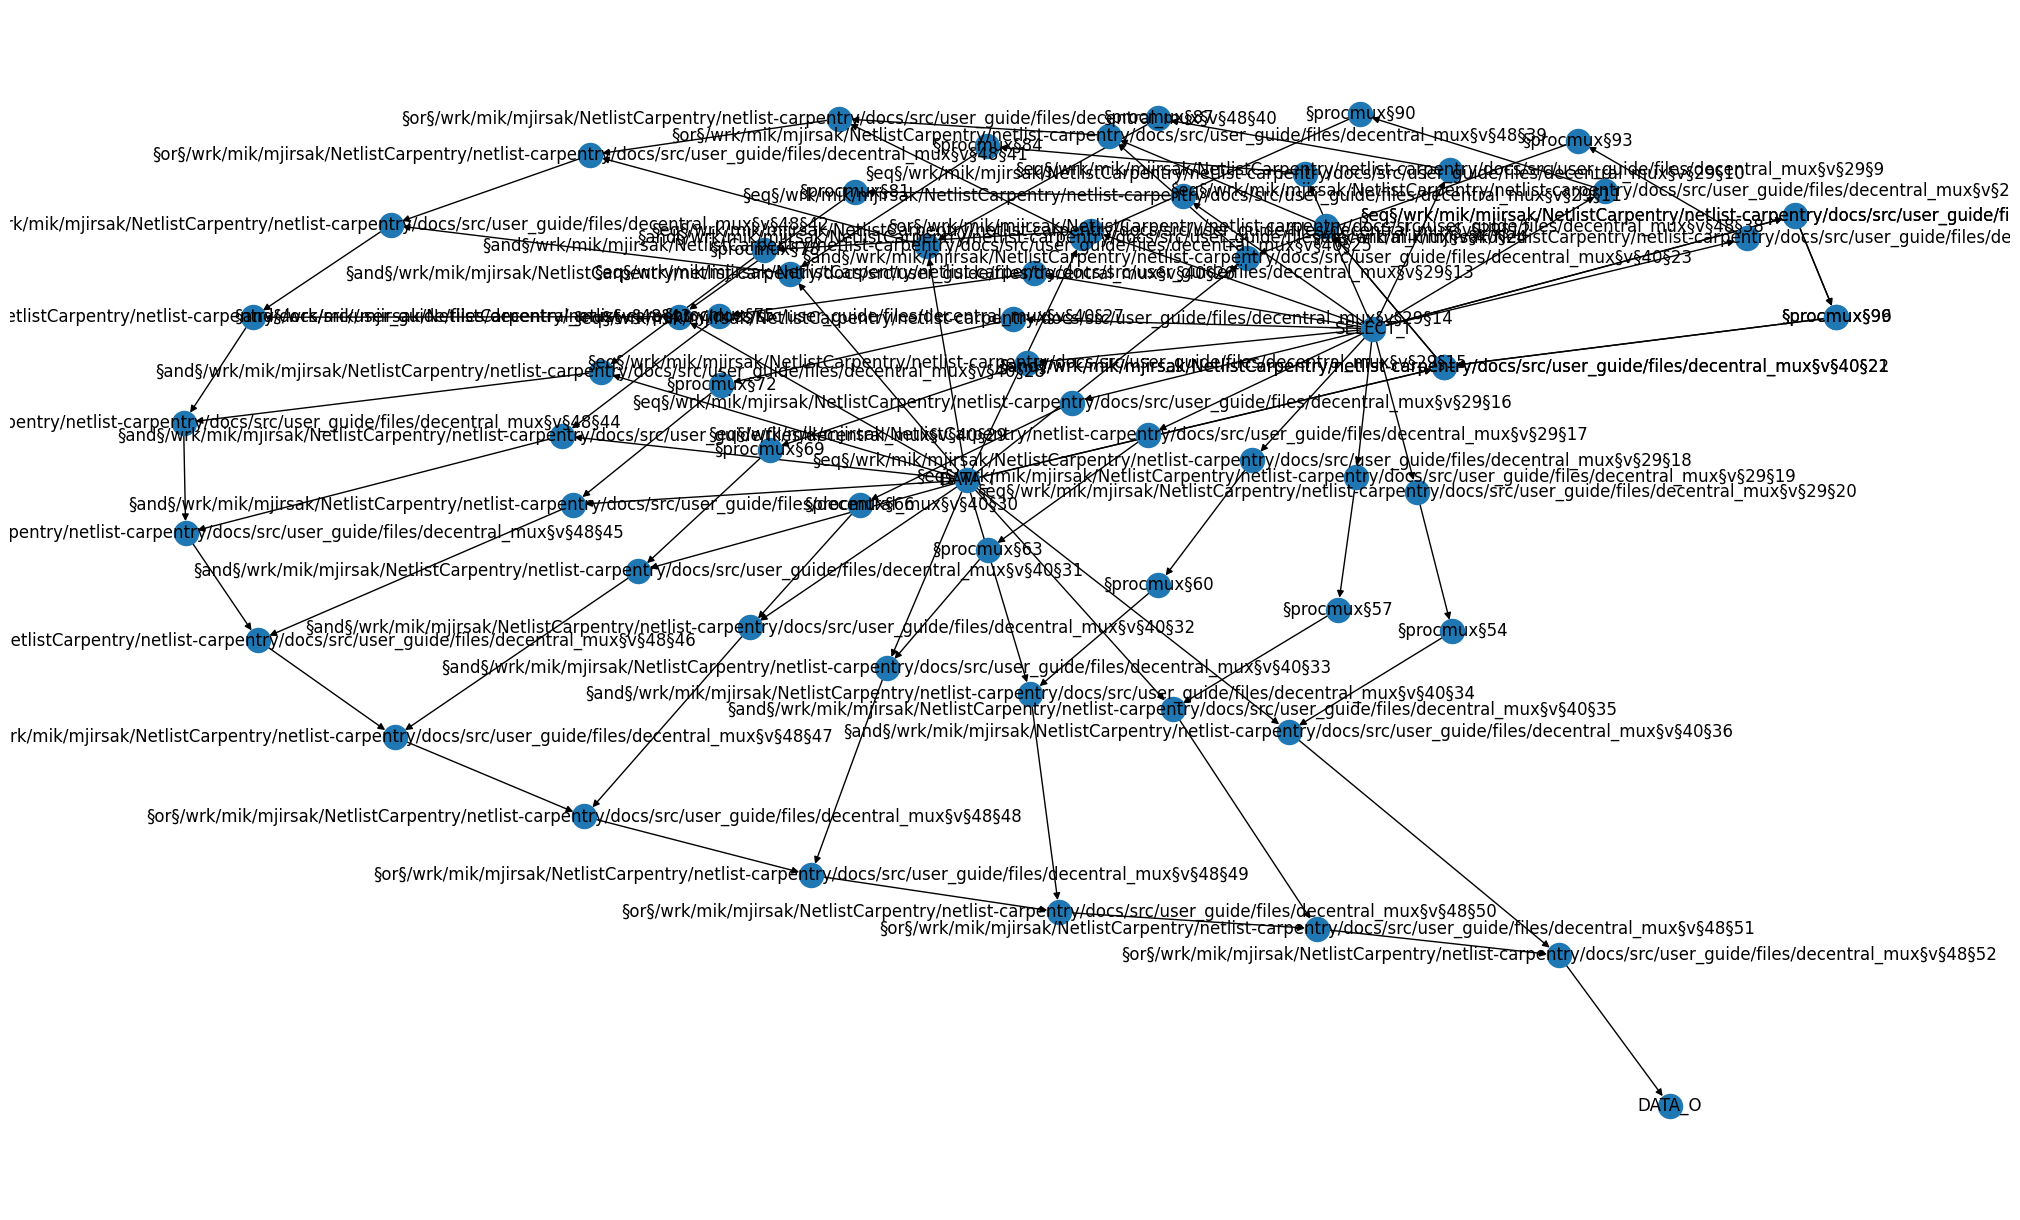

In [4]:
import matplotlib.pyplot as plt

pos = nx.kamada_kawai_layout(optimized_module_graph)

plt.figure(figsize=(20, 12))
nx.draw(optimized_module_graph, pos, with_labels=True)
plt.show()

- To further customize the presented graph, nodes can be colored and labelled differently, depending on additional data.
- For example, the nodes can be colored differently depending on their type (input, output or internal instance).
- This can be retrieved from the module graph using the `ntype` (node type) and `ntype_info` (node type additional info) attributes.
- The `ntype` attribute contains the superordinate type of the node (i.e. whether it is a port or an instance), whereas `ntype_info` describes additional information, such as the direction of a port (e.g. `input`, `output`) or the type of the instance.
- This information can be used to color the nodes differently as well as relabel them for better readability.
- Execute the cell below to render a colored graph using the `node_color` and `labels` parameters, where inputs are green, outputs are red, and all other nodes are blue.


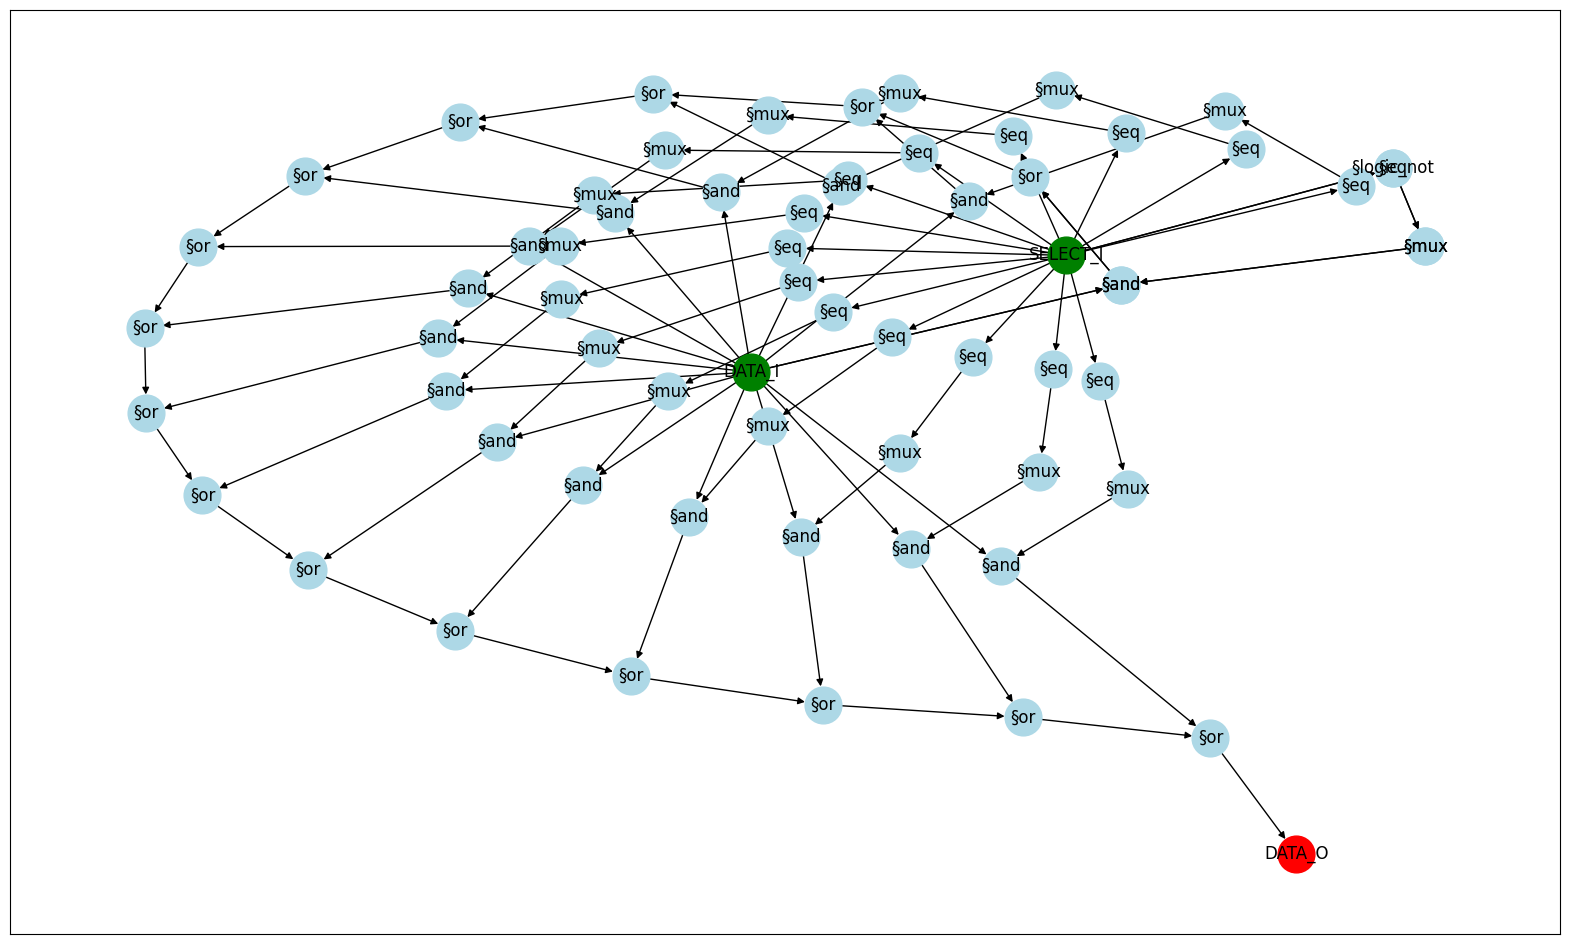

In [5]:
input_nodes = []
output_nodes = []
other_nodes = []
labels = {}

for node in optimized_module_graph.nodes:
    ntype = optimized_module_graph.nodes[node]["ntype_info"]
    if ntype == "input":
        input_nodes.append(node)
        labels[node] = node
    elif ntype == "output":
        output_nodes.append(node)
        labels[node] = node
    else:
        other_nodes.append(node)
        labels[node] = ntype

pos = nx.kamada_kawai_layout(optimized_module_graph)

plt.figure(figsize=(20, 12))
nx.draw_networkx_nodes(optimized_module_graph, pos, nodelist=input_nodes, node_size=700, node_color="green")
nx.draw_networkx_nodes(optimized_module_graph, pos, nodelist=output_nodes, node_size=700, node_color="red")
nx.draw_networkx_nodes(optimized_module_graph, pos, nodelist=other_nodes, node_size=700, node_color="lightblue")
nx.draw_networkx_edges(optimized_module_graph, pos, node_size=700)
nx.draw_networkx_labels(optimized_module_graph, pos, labels)

plt.show()

- Within Netlist Carpentry, there is also a class `Visualization`, which is intended to make visual depiction of graphs easier, providing a bunch of methods for customized graph representations.
- The method `Visualization.visualize_in_out` does the same as the previous cell, and is also capable of assigning colors to the corresponding nodes.
- Execute the cell below, to recreate the same image as above, but with different coloring.

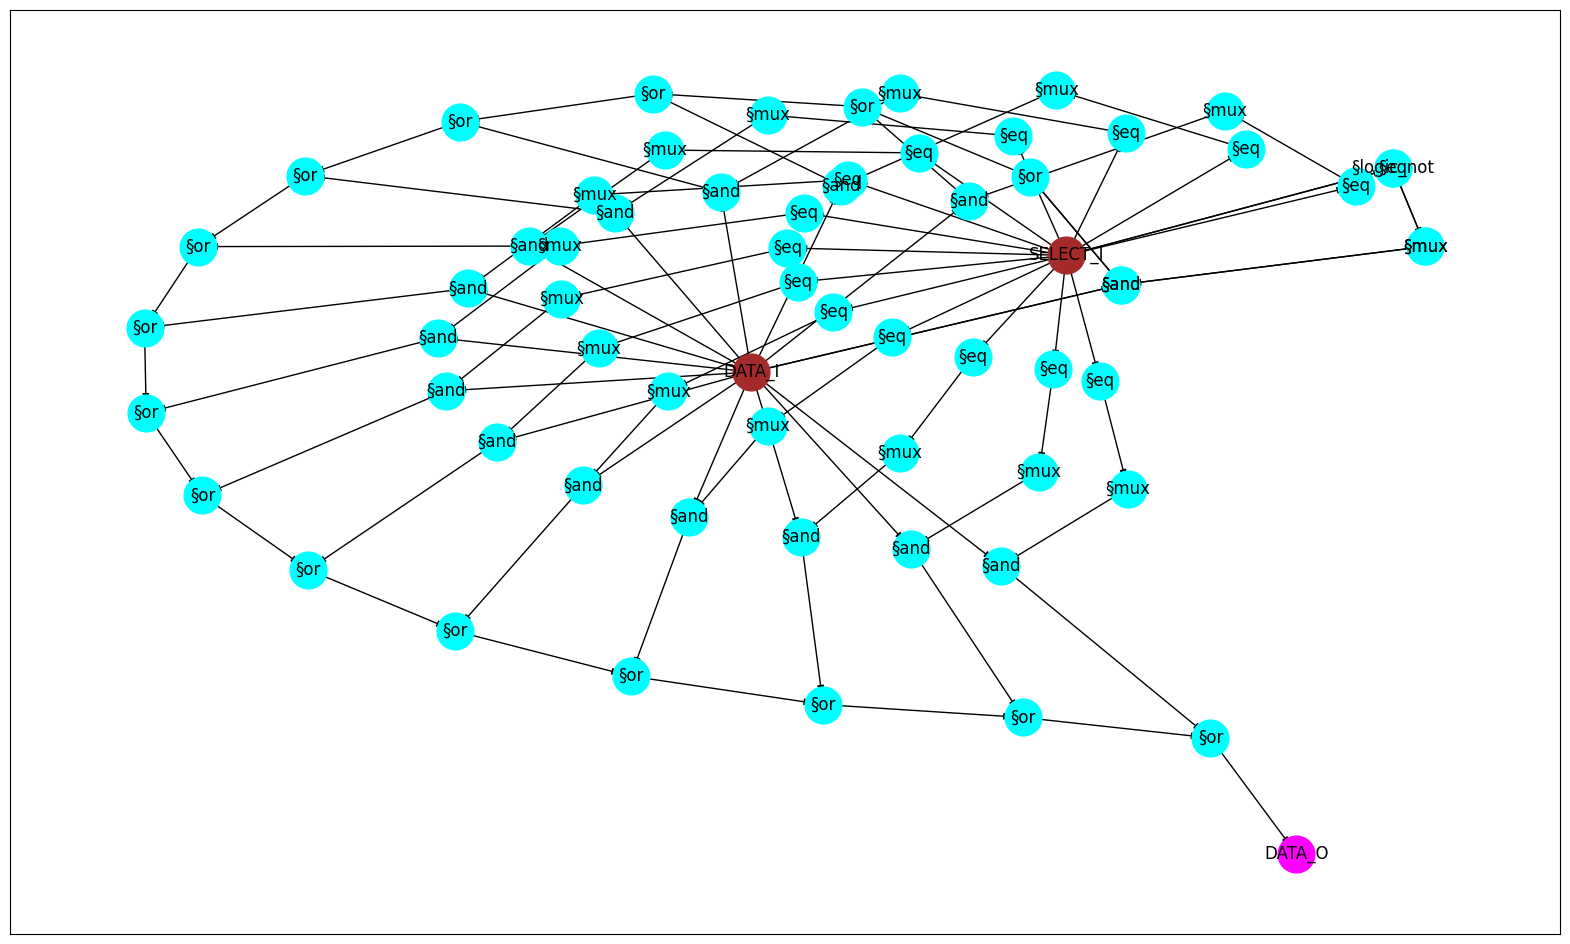

In [6]:
from netlist_carpentry.core.graph.visualization import Visualization

vis = Visualization(optimized_module_graph)
vis.visualize_in_out(figsize=(20, 12), in_color="brown", out_color="magenta", default_color="cyan")

- Individual nodes can be formatted using `Visualization.format_node`.
- Afterwards, using `Visualization.visualize` (which can be given a certain size), the graph is shown according to the previously executed formatting.
- Execute the cell below to change the color of the input node `SELECT_I` to bright green.

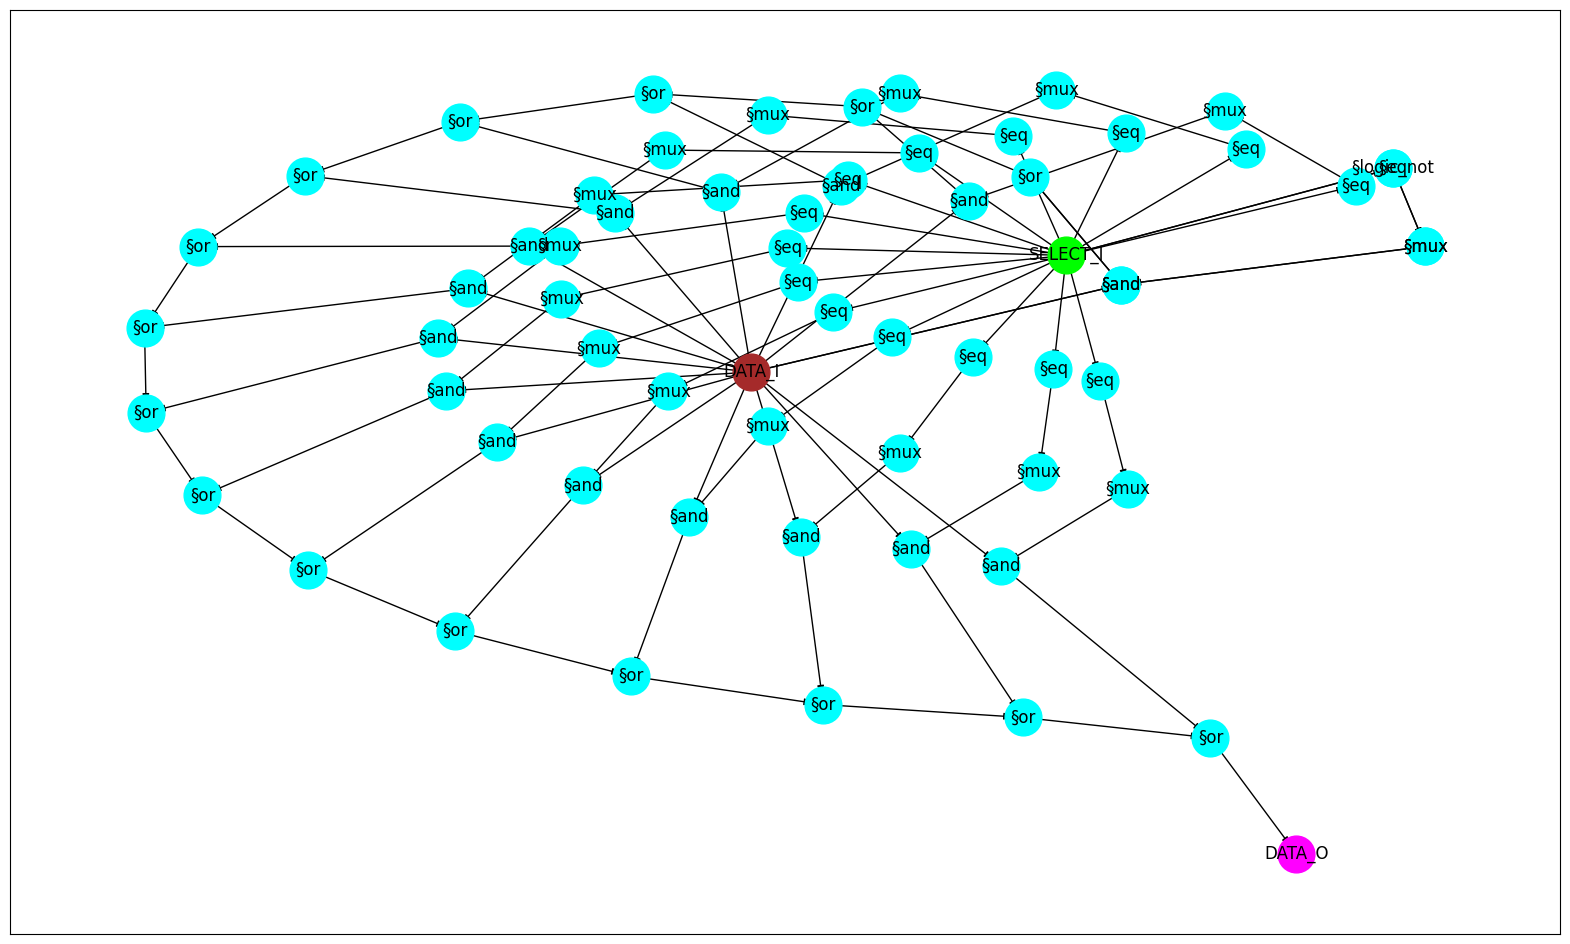

In [7]:
vis.format_node('SELECT_I', node_color='#00FF00')
vis.visualize(figsize=(20, 12))

- Nodes can also be formatted based on a filter using the `Visualization.format_nodes` method.
- The filter can be a lambda function, based on the node name or the node data.
- Execute the cell below to format all nodes, whose data entry for `ntype_info` (i.e. the instance type) is `§or` - this will select all OR gate instances - and highlight them by coloring them orange and making them larger than the rest.

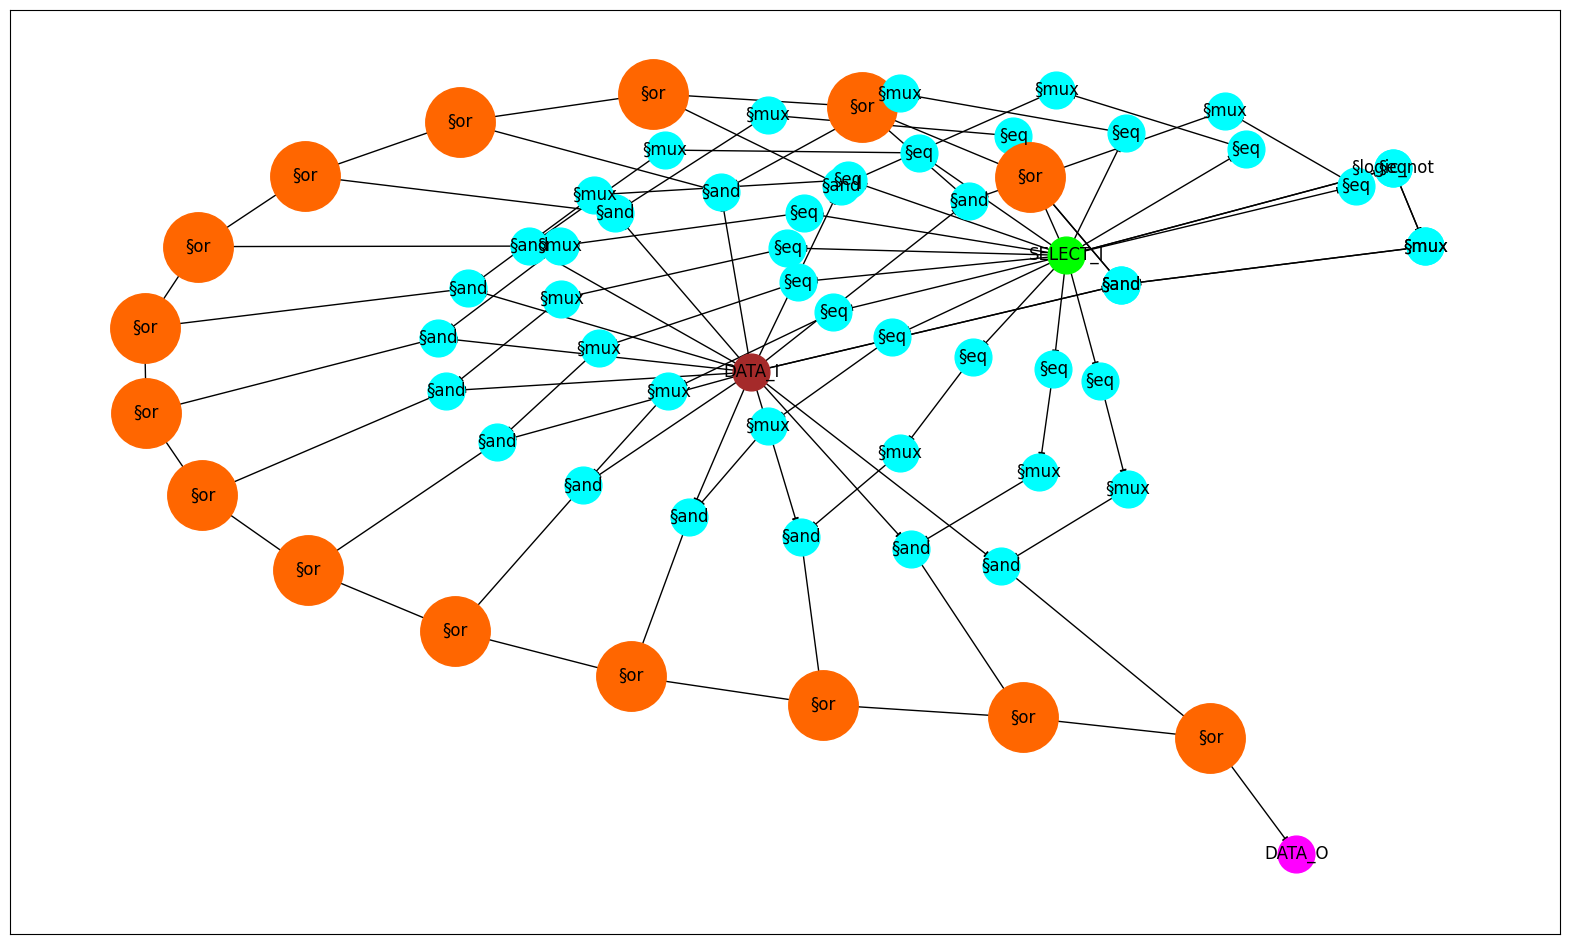

In [8]:
vis.format_nodes(lambda node_name, data: data.get("ntype_info") == "§or", node_color="#FF6600", node_size=2500)
vis.visualize(figsize=(20, 12))

- In an alternative case, all nodes with similar names could possibly be highlighted.
- This is also possible via the lambda function, now utilizing `node_name` instead of `data`.
- Execute the cell below to color all nodes with `data` (case-insensitive) in their names in dark blue.


<div class="admonition info alert alert-info">
  <strong>Info:</strong> Notice how previous formatting is overwritten, making DATA_I and DATA_O now the same color.
</div>

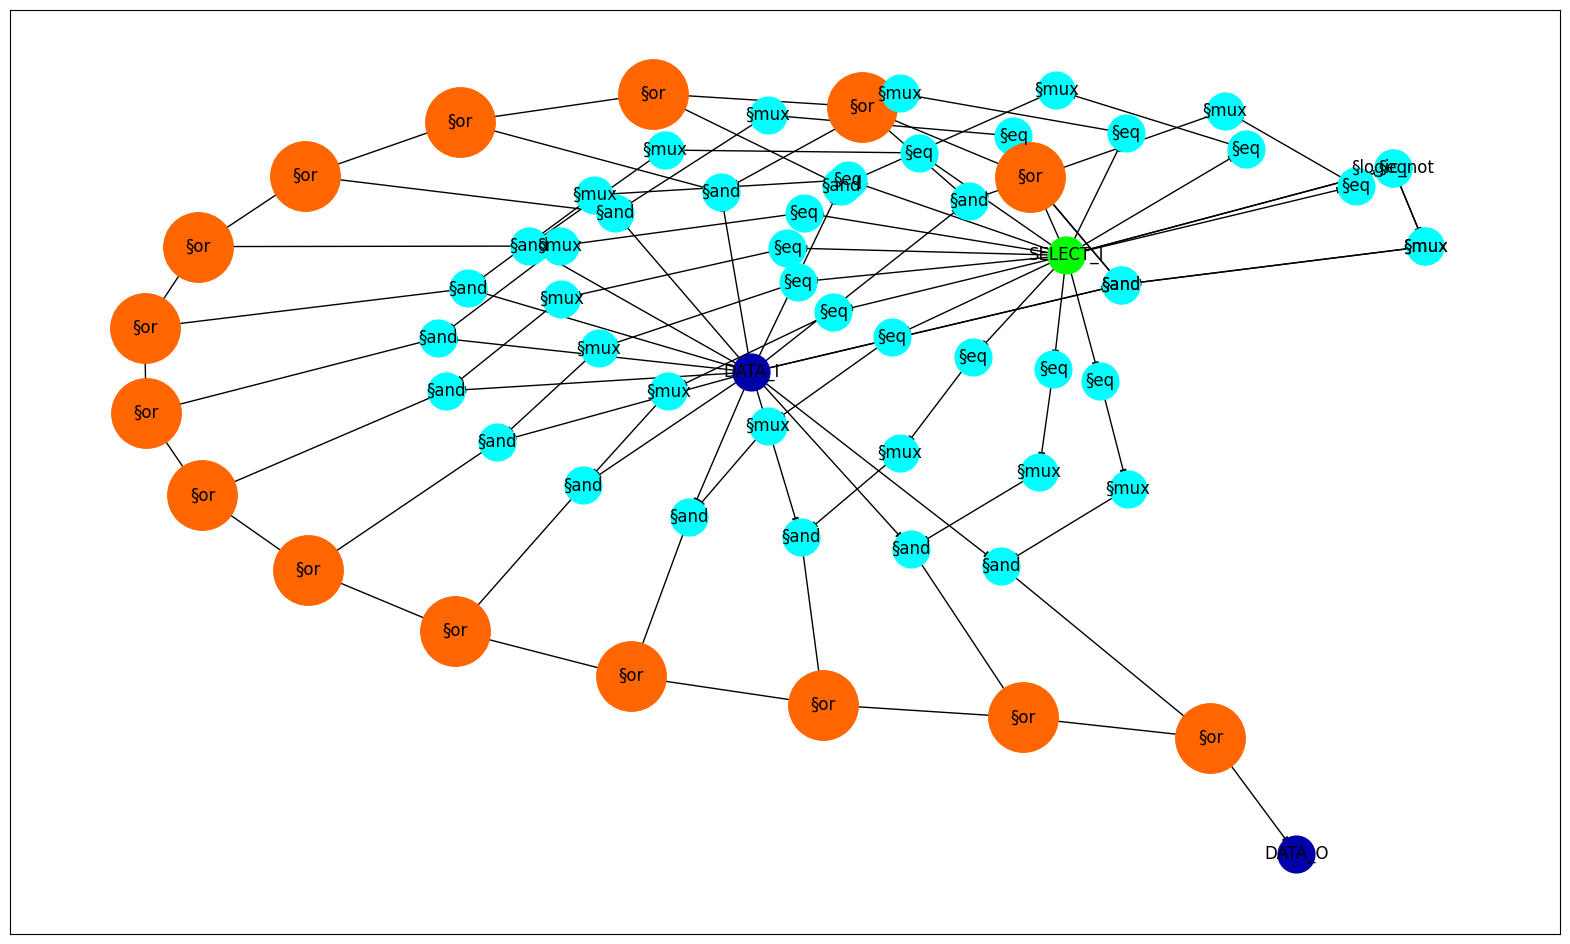

In [9]:
vis.format_nodes(lambda node_name, data: "data" in node_name.lower(), node_color="#0000AA")
vis.visualize(figsize=(20, 12))

## Exporting Graphs
- Using networkx, graphs can be exported and displayed visually, for which a method is also included into the `Visualization` class.
- `Visualization.export_graphml` exports the graph into the graphml format into a file so that it can be represented by external software, e.g. Gephi.
- Execute the cell below so that a graphml file is created, which contains the module graph of the decentral mux to be viewed in an appropriate graph displaying software.

In [10]:
vis.export_graphml('output/decentral_mux.graphml')